In [8]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from utils.helpers.pandas_helpers import keep_levels, index_slice
from objects.signals.individual.momentum import Momentum
from objects.signals.individual.fair_value.pca import PCA
from objects.signals.combination.simple_combination import SignalSelector
from objects.signals.combination.ml_combination import MLSignalSelector
from objects.data_manipulation.normalizer import Normalizer
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:

investment_universe = [
    'ADA/USDC:USDC',
    'DOT/USDC:USDC',
    'SOL/USDC:USDC',
    'XRP/USDC:USDC',
    'BTC/USDC:USDC',
    'ETH/USDC:USDC']

In [262]:
df= pd.read_parquet('/Users/educontreras/PycharmProjects/crypto_signals/objects/retriever/hourly_prices.parquet')
pca_df= pd.read_parquet('/Users/educontreras/PycharmProjects/crypto_signals/objects/retriever/fair_value.parquet')
df.columns = df.columns.rename("field", level=0)
close_df = keep_levels(index_slice(df, field = 'close'), ['symbol'])

df_subset = close_df.loc[:, investment_universe]
returns_df = df_subset.pct_change().dropna(how = 'any')

In [263]:
pca_df =  PCA.rolling_pca(df_subset, windows = [365])

2024-12-22 22:07:32.102 | INFO     | objects.signals.individual.fair_value.pca:rolling_pca:23 - Starting rolling PCA computation
2024-12-22 22:07:32.105 | INFO     | objects.signals.individual.fair_value.pca:rolling_pca:29 - Processing rolling PCA for window size 365
2024-12-22 22:07:48.189 | SUCCESS  | objects.signals.individual.fair_value.pca:rolling_pca:101 - Rolling PCA computation completed


2024-12-22 22:08:02.032 | INFO     | objects.data_manipulation.normalizer:compute_z_scores:18 - Starting Z-Score computation
2024-12-22 22:08:02.033 | INFO     | objects.data_manipulation.normalizer:compute_z_scores:22 - Computing Z-Score for window size 365
2024-12-22 22:08:02.103 | SUCCESS  | objects.data_manipulation.normalizer:compute_z_scores:50 - Z-Score computation completed


<Axes: xlabel='timestamp'>

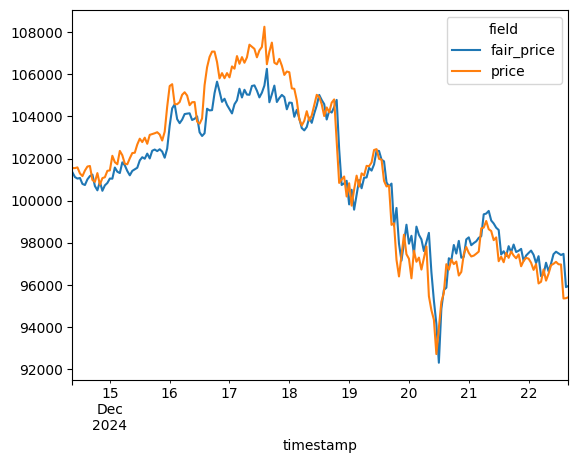

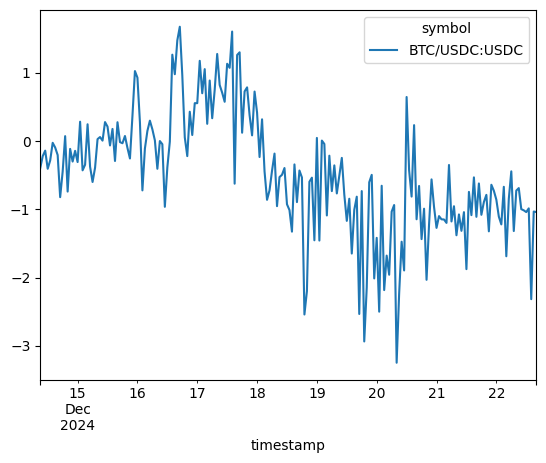

In [264]:
fv_df = keep_levels(index_slice(pca_df, symbol = 'BTC/USDC:USDC', period = 365, field = ['fair_price', 'price']), ['field']).dropna()
diff_df = keep_levels(index_slice(pca_df, period = 365, field = ['difference']), ['symbol']).dropna()
z_df = Normalizer.compute_z_scores(diff_df, windows = [365])
z_plot = keep_levels(index_slice(z_df, symbol = 'BTC/USDC:USDC', period = 365), ['symbol'])
fv_df.tail(200).plot()
z_plot.tail(200).plot()

In [274]:

import numpy as np
import pandas as pd

class Position:
    @staticmethod
    def mean_reversion(signal_df, long_entry_level, long_exit_level, short_entry_level, short_exit_level, number_days_confirmation=0):
        """
        Generate trading signals based on a mean-reversion strategy with confirmation.

        Args:
        - signal_df (pd.DataFrame): DataFrame containing the signal data.
        - long_entry_level (float): Signal level below which to enter long positions.
        - long_exit_level (float): Signal level above which to exit long positions.
        - short_entry_level (float): Signal level above which to enter short positions.
        - short_exit_level (float): Signal level below which to exit short positions.
        - number_days_confirmation (int): Number of days to confirm the signal before acting. Default is 0.

        Returns:
        - pd.DataFrame: DataFrame with the same shape as `signal_df` containing -1, 0, or 1.
        """
        signals = np.zeros_like(signal_df.values)  # Initialize signals to neutral (0)
        signal_array = signal_df.values
        num_days = signal_array.shape[0]
        num_assets = signal_array.shape[1]

        for day in range(num_days):
            for col in range(num_assets):
                # Check if a position is active
                if day > 0 and signals[day - 1, col] == 1:  # Active long position
                    if signal_array[day, col] > long_exit_level:  # Exit long condition
                        signals[day, col] = 0
                    else:  # Hold the long position
                        signals[day, col] = 1

                elif day > 0 and signals[day - 1, col] == -1:  # Active short position
                    if signal_array[day, col] < short_exit_level:  # Exit short condition
                        signals[day, col] = 0
                    else:  # Hold the short position
                        signals[day, col] = -1

                elif signals[day - 1, col] == 0:  # No active position
                    # Long entry condition
                    if day >= number_days_confirmation and (signal_array[day - number_days_confirmation:day + 1, col] < long_entry_level).all():
                        signals[day, col] = 1  # Enter long if confirmed

                    # Short entry condition
                    elif day >= number_days_confirmation and (signal_array[day - number_days_confirmation:day + 1, col] > short_entry_level).all():
                        signals[day, col] = -1  # Enter short if confirmed

        return pd.DataFrame(signals, index=signal_df.index, columns=signal_df.columns)
    @staticmethod
    def trend_following(
        signal_df,
        long_entry_level,
        long_exit_level,
        short_entry_level,
        short_exit_level,
        number_days_confirmation=0,
        max_holding_period=None
    ):
        """
        Generate trading signals based on a trend-following strategy with confirmation.

        Args:
        - signal_df (pd.DataFrame): DataFrame containing the signal data.
        - long_entry_level (float): Signal level above which to enter long positions.
        - long_exit_level (float): Signal level above which to exit long positions (higher than entry level).
        - short_entry_level (float): Signal level below which to enter short positions.
        - short_exit_level (float): Signal level below which to exit short positions (lower than entry level).
        - number_days_confirmation (int): Number of days to confirm the signal before acting. Default is 0.
        - max_holding_period (int or None): Max number of days to hold a position. Default is None (no limit).

        Returns:
        - pd.DataFrame: DataFrame with the same shape as `signal_df` containing -1, 0, or 1.
        """
        signals = np.zeros_like(signal_df.values)  # Initialize all signals to neutral (0)
        signal_array = signal_df.values
        num_days = signal_array.shape[0]
        num_assets = signal_array.shape[1]

        # Iterate day by day
        for day in range(1, num_days):  # Start from day 1, we need to check the previous day
            for col in range(num_assets):
                # Check if there is no active position from yesterday (i.e., neutral state)
                if signals[day - 1, col] == 0:
                    # Check if the current value exceeds the entry level for long or short position
                    if signal_array[day, col] > long_entry_level:
                        # Confirm the signal if the condition is sustained for the number of confirmation days
                        if day >= number_days_confirmation and all(
                                signal_array[day - number_days_confirmation:day + 1, col] > long_exit_level):
                            signals[day, col] = 1  # Enter long position

                    elif signal_array[day, col] < short_entry_level:
                        # Confirm the signal if the condition is sustained for the number of confirmation days
                        if day >= number_days_confirmation and all(
                                signal_array[day - number_days_confirmation:day + 1, col] < short_exit_level):
                            signals[day, col] = -1  # Enter short position

                # For active long position (signals[day-1] == 1)
                elif signals[day - 1, col] == 1:
                    if signal_array[day, col] < long_exit_level:
                        signals[day, col] = 0  # Exit long position if the price exceeds long_exit_level
                    elif max_holding_period and (day - np.where(signals[:, col] == 1)[0][0]) >= max_holding_period:
                        signals[day, col] = 0  # Exit after max holding period
                    else:
                        signals[day, col] = 1  # Continue holding the long position

                # For active short position (signals[day-1] == -1)
                elif signals[day - 1, col] == -1:
                    if signal_array[day, col] > short_exit_level:
                        signals[day, col] = 0  # Exit short position if the price falls below short_exit_level
                    elif max_holding_period and (day - np.where(signals[:, col] == -1)[0][0]) >= max_holding_period:
                        signals[day, col] = 0  # Exit after max holding period
                    else:
                        signals[day, col] = -1  # Continue holding the short position

        return pd.DataFrame(signals, index=signal_df.index, columns=signal_df.columns)
    
p = Position.trend_following(z_df, 1, 0, -1, -0, number_days_confirmation=0)


<Axes: xlabel='timestamp'>

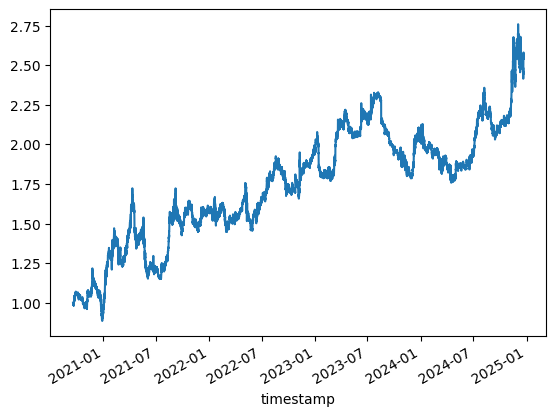

In [275]:
profits = p.shift(1) * returns_df
(profits + 1).mean(axis = 1).cumprod().dropna().plot()

In [260]:
p, returns = p.align(returns_df, join='inner', axis=0)
profits = p.shift(1) * returns
profits

symbol,ADA/USDC:USDC,BTC/USDC:USDC,DOT/USDC:USDC,ETH/USDC:USDC,SOL/USDC:USDC,XRP/USDC:USDC
period,365,365,365,365,365,365
timestamp,,,,,,
2022-08-17,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-18,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000
2022-08-19,-0.000000,-0.000000,-0.000000,-0.000000,0.093877,-0.000000
2022-08-20,0.000000,0.000000,-0.000000,-0.000000,0.014800,0.000000
2022-08-21,0.000000,0.000000,0.000000,0.000000,-0.033730,0.000000
...,...,...,...,...,...,...
2024-12-18,-0.079928,0.055870,0.095204,0.068382,0.074479,-0.100105
2024-12-19,-0.000000,0.027366,0.096106,0.057844,0.061589,-0.030862


<Axes: xlabel='timestamp'>

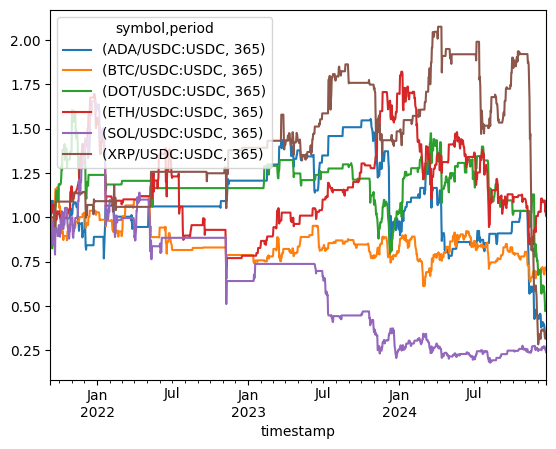

In [201]:
((profits + 1).cumprod()).plot()